### Experiment 4

breast-cancer mass specotmetry data

Considered 100 images where each channel is considered as a separate image

In [1]:
! nvidia-smi

Wed Jun 12 15:34:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76.01              Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        On  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              5W /   80W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import sys
sys.path.append('../../gap/')
from GAP_UNET_ResBlock import UN
from BinomDataset import BinomDataset
from inference import sample_image

# Data
The data will be published shortly.
Links will be provided here.
Importantly, pixel values should contain photon counts and images should not be significantly affected by other types of noise.

# Training

### Loading the data
_________________

We load the data. We can use the full dataset for training, since this is self-supervised and we do not require ground truth.

In [3]:
# Use low SNR data
# data = np.concatenate((imread('data/trainingData.tif'), imread('./data/testData.tif')))

# Use low SNR data
# data = np.concatenate((imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/trainingData.tif'), imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testData.tif')))

data = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/formatted-breast-cancer/cropped/trainingDataPart-1.tif')

(10000, 256, 256)


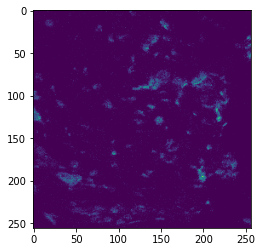

In [4]:
plt.imshow(data[0])
print(data.shape)

In [4]:
def psnrToString(inp):
    if inp < 0:
        return 'm'+str(-inp)
    else:
        return str(inp)

# we set the pseudo PSNR range used for splitting the images into input and target
minpsnr = -40
maxpsnr = -5
experiment_no = '-exp-4'
name = psnrToString(minpsnr)+"to"+psnrToString(maxpsnr)+"-256x256"+experiment_no
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'


In [6]:
name

'm40tom5-256x256-exp-4'

In [7]:
data = data[:5000]
data.shape

(5000, 256, 256)

In [8]:
maxepochs = 30 # train longer for better results

# Create pytorch dataset
dataset = BinomDataset(data[:round(data.shape[0]*0.9)], 256, minpsnr, maxpsnr, virtSize = 500*32)
val_dataset = BinomDataset(data[round(data.shape[0]*0.9):], 256, minpsnr, maxpsnr)


In [9]:
# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True, pin_memory=False) ## Changing the batch size from 32 to 16 to fit inside the gpu
val_loader = dt.DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False,  pin_memory=False) ### Changing num_workers from 12 to 4, check the memory usage

img =  next(iter(val_loader))

print(img.shape)


trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     gpus = [0], devices = [0],
                     max_epochs=maxepochs, 
                     callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=2000)])

model = UN(channels = 1, levels=10, depth=6,
                 start_filts=28, up_mode = 'transpose').to(device)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([16, 2, 256, 256])


In [10]:
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | conv_final | Conv2d     | 29    
1 | down_convs | ModuleList | 24.1 M
2 | up_convs   | ModuleList | 9.4 M 
------------------------------------------
33.4 M    Trainable params
0         Non-trainable params
33.4 M    Total params
133.774   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Denoising

In [5]:
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP

In [37]:
dataTest = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/formatted-breast-cancer/cropped/testData-1.tif')[12:13]     # to speed things up, we are only doing the first image
# dataTestGT =imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')[:1]
dataTest.shape

(1, 256, 256)

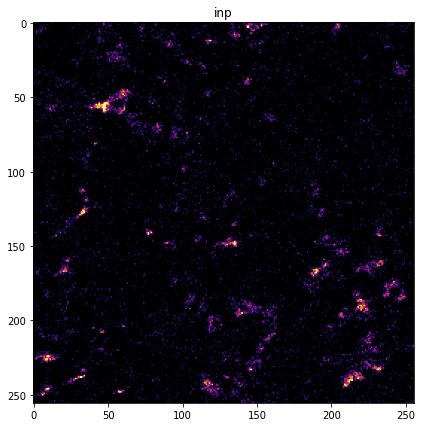

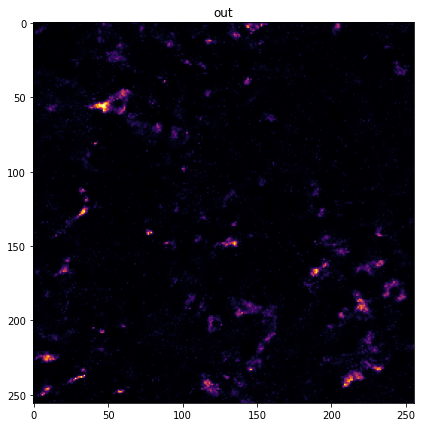

: 

In [39]:
outputs = []
for inp in dataTest:  
    inpT = torch.from_numpy(inp.astype(np.float32)).to(device)
    # We have to apply softmax over pixels
    out = torch.exp(model(inpT[None,None,...]).detach().cpu())
    out = inp.sum() * out / out.sum() ## multiply noisy image with probability distribution of clean image?
    outputs.append(out.numpy()[0,0])
    
    # print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))
    
    inp = inp/inp.mean()
    out = out/out.mean()
    # gt = gt/gt.mean()
    # vmax = np.percentile(gt,99.9)
    
    plt.figure(figsize=(7,7))
    plt.imshow(inp[:500,:500],vmin = 0, vmax = np.percentile(out, 99.99), cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,0][:500,:500],vmin = 0,vmax = np.percentile(out, 99.99), cmap = "inferno")
    plt.title('out')
    plt.show()
    
    # plt.figure(figsize=(7,7))
    # plt.imshow(gt[:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    # plt.title('GT')
    # plt.show()


In [13]:
# outputs = np.array(outputs)
# imsave('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/output-lowres.tif',outputs, imagej = True)

# Sampling images

(1, 1, 256, 256)


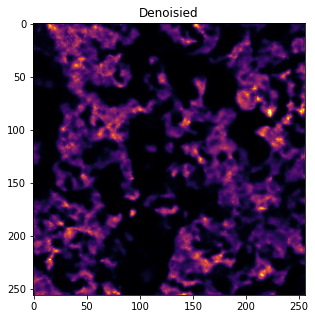

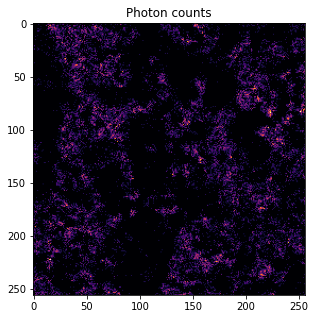

_______________________________________ 153
time (s): 3.0907363891601562 time per image (s) 3.0907363891601562


In [27]:
import matplotlib.image as mpimg
import time
import numpy as np

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 256
pixels_y = 256

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x).to(device)


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(inp_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = -5)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)

            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Denoisied')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   

## Looking at the intermediate outputs

0


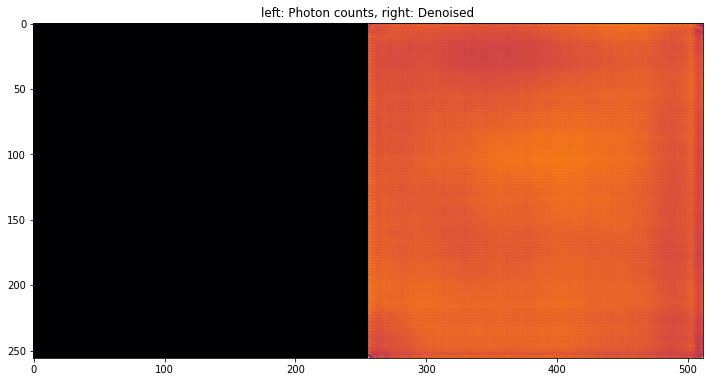

1


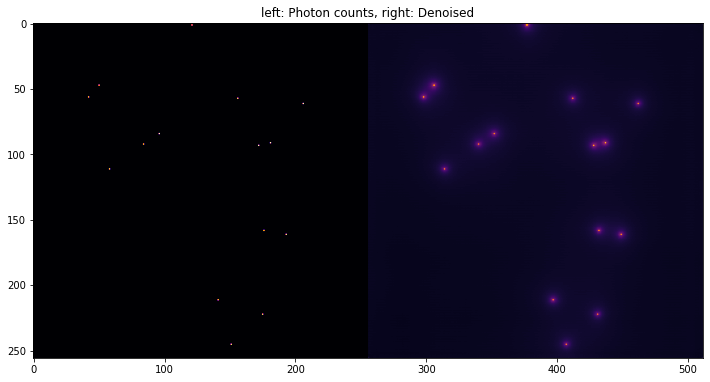

2


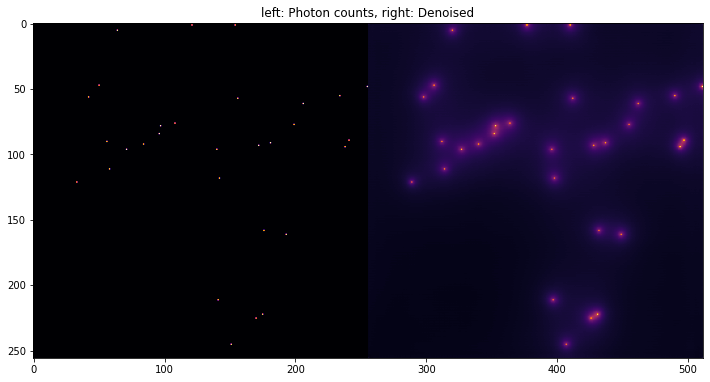

3


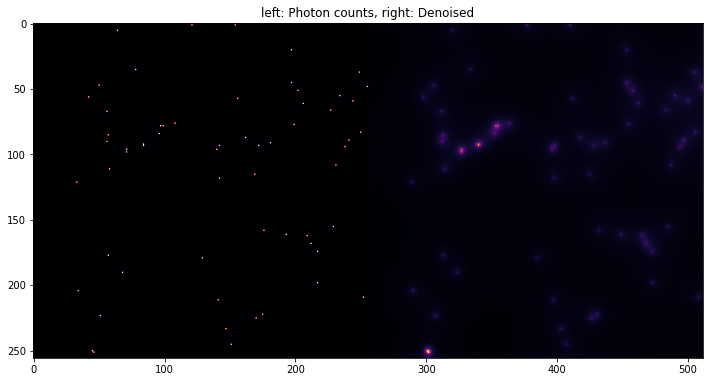

4


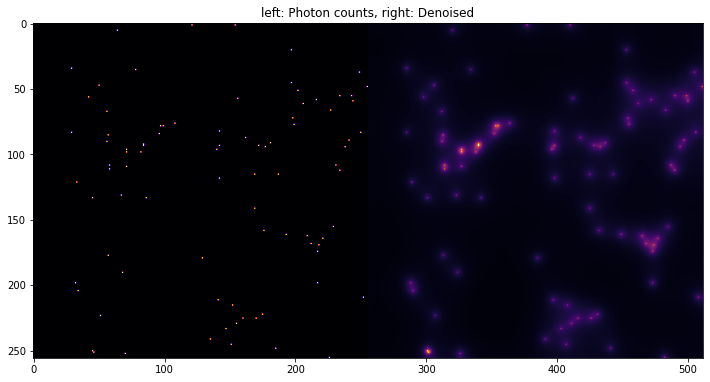

5


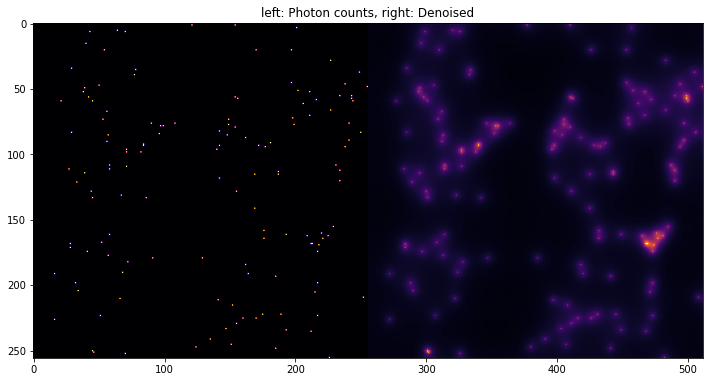

6


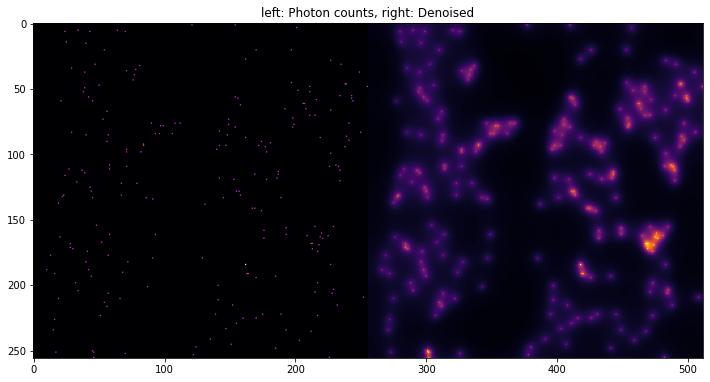

7


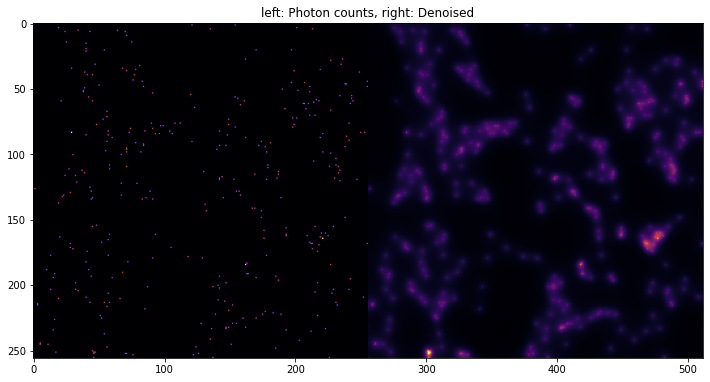

8


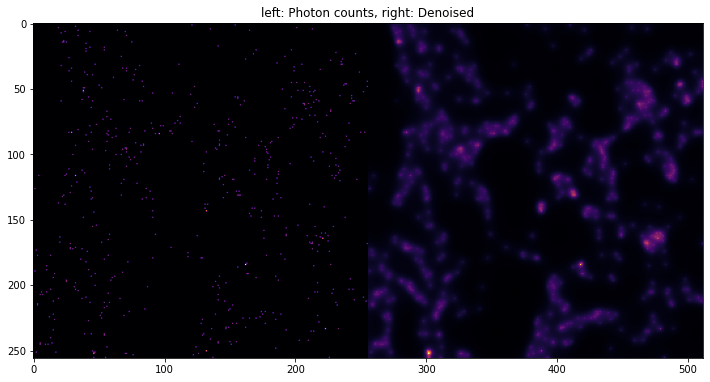

9


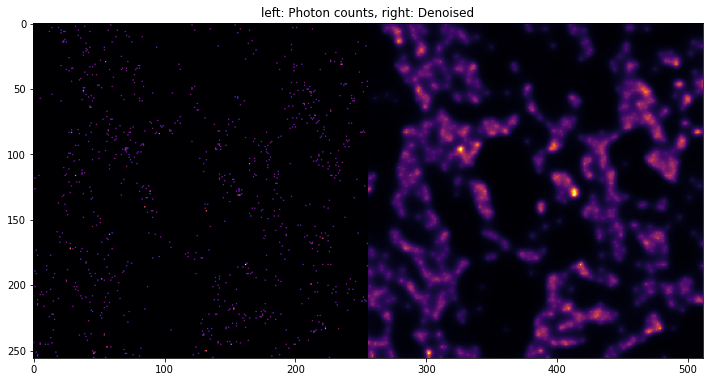

10


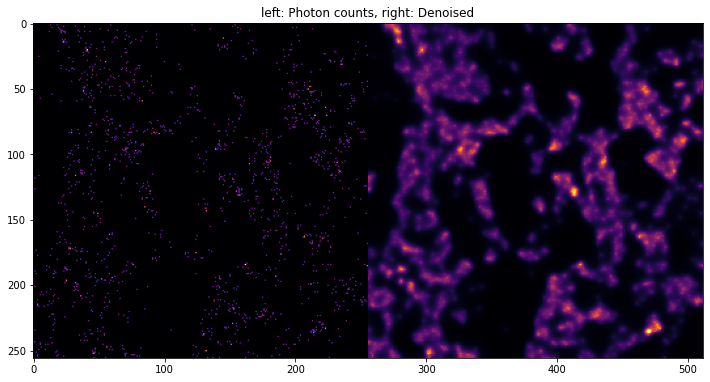

11


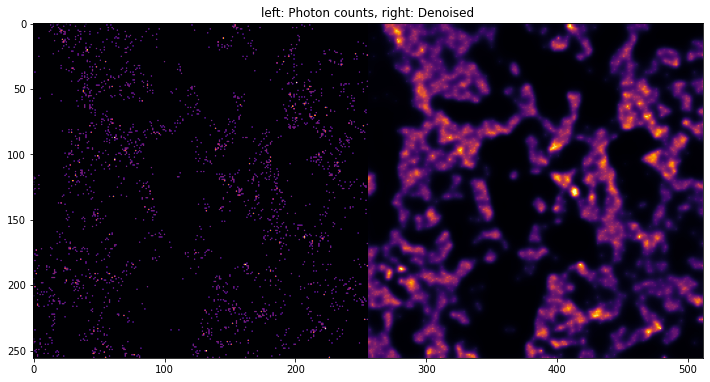

12


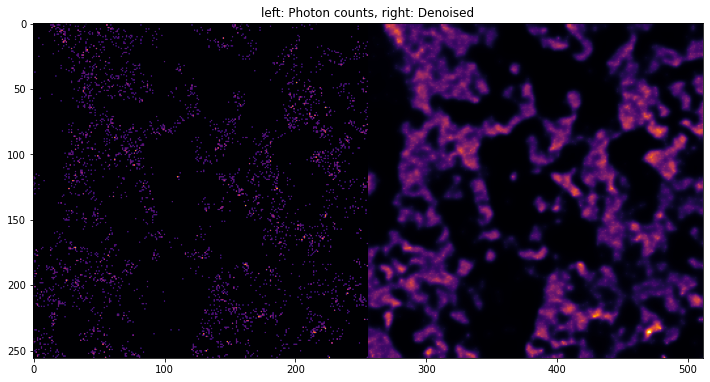

13


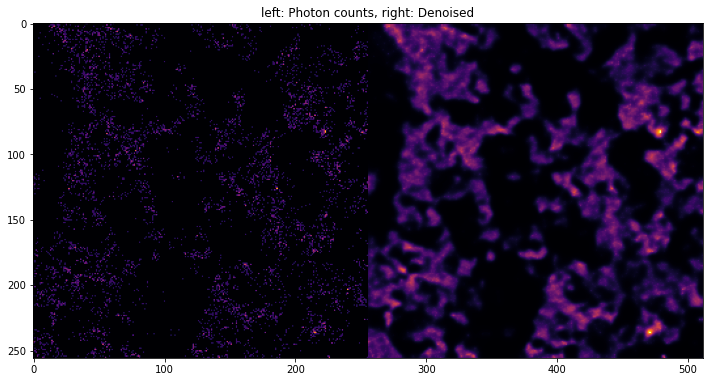

14


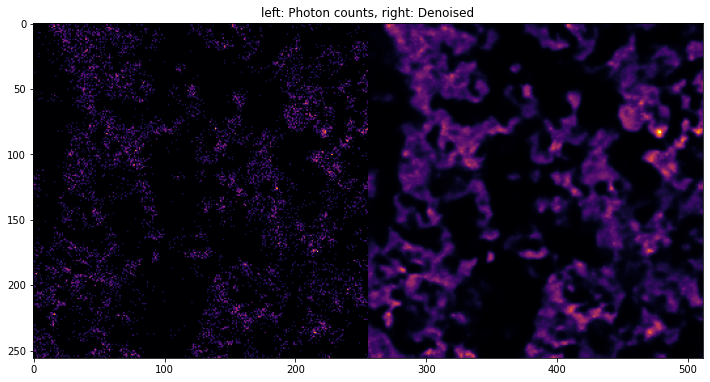

15


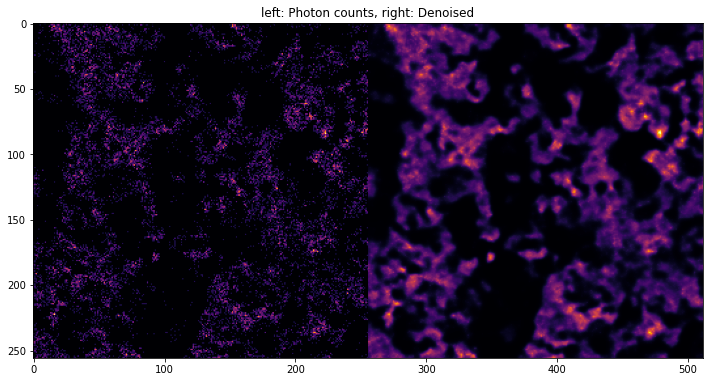

In [28]:
stack[0].shape
for i in range(len(stack)):
    im = stack[i]
    print(i)
    plt.figure(figsize = (12,12))
    plt.imshow(im,cmap ='inferno', vmax = 0.9)
    plt.title('left: Photon counts, right: Denoised')
    plt.show()